In [302]:
import numpy as np
import pandas as pd
# import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV

# from datetime import datetime

# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
class DataPreprocessing():
    """Подготовка исходных данных"""    
    
    def transform(self, X):
        # заменяем некорректные Rooms на средние
        cond_rooms_1 = ((X['Rooms'] >= 6) | (X['Rooms'] == 0)) & X['Square'] < 100
        cond_rooms_2 = ((X['Rooms'] >= 6) | (X['Rooms'] == 0)) & X['Square'] > 100
            
        # нулевые или больше 6 при площади меньше 100 заменяем на средние
        X.loc[cond_rooms_1, 'Rooms'] = X['Rooms'].median()
        # нулевые или больше 6 при площади меньше 100 заменяем на 6
        X.loc[cond_rooms_2, 'Rooms'] = 6
            
        # заменяем слишком большие KitchenSquare на квантиль 975
        kitsquare_quant = X['KitchenSquare'].quantile(.975)
        X.loc[X["KitchenSquare"] > kitsquare_quant, "KitchenSquare"] = kitsquare_quant
            
        # заменяем слишком маленькие Square на сумму Square + KitchenSquare
        cond_square_sum = X["LifeSquare"] + X["KitchenSquare"]
        X.loc[X["Square"] < cond_square_sum, "Square"] = cond_square_sum
            
        # находим и заменяем некорректные HouseFloor (0 или меньше чем текущий Floor)
        cond_floor = (X['Floor'] > X['HouseFloor']) | (X['HouseFloor'] == 0)            
        X.loc[cond_floor, "HouseFloor"] = X.loc[cond_floor, "Floor"]
            
        # заменяем все даты больше 2021 на 2021
        X.loc[X['HouseYear'] > 2021, "HouseYear"] = 2021            
        # заменяем все даты меньше 1000 на 1000
        X.loc[X['HouseYear'] < 1000, "HouseYear"] = 1000
            
        # Пропуски LifeSquare заменяем на разницу между (Square - Kitchen Square) * 0.8
        life_sq_cond = X["LifeSquare"].isna()
        X.loc[life_sq_cond, "LifeSquare"] = (X.loc[life_sq_cond, "Square"] - X.loc[life_sq_cond, "KitchenSquare"]) * 0.8
            
        # удаляем колонку с пропусками HealthCare_1
        X.drop('Healthcare_1', axis=1, inplace=True)
        
        return X

In [338]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def transform(self, X):        
        # содаем District_Size на основе колва значений в DistrictID
        district_size = X["DistrictId"].value_counts().reset_index() \
                               .rename(columns={"index":"DistrictId", "DistrictId":"DistrictSize"})
        X = X.merge(district_size, on="DistrictId", how="left")
        
        
        # конвертируем колонки с текстом в цифровые признаки
        binary_to_numbers = {"A": 0, "B": 1}
        X["Ecology_2"] = X["Ecology_2"].map(binary_to_numbers)
        X["Ecology_3"] = X["Ecology_3"].map(binary_to_numbers)
        X["Shops_2"] = X["Shops_2"].map(binary_to_numbers)
        
        return X

In [104]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [339]:
# задаем пути
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [379]:
# читаем тренировочные исходные данные
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [380]:
# читаем тестовые исходные данные
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [381]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_names = ["DistrictSize"]
target_name = "Price"
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [382]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [383]:
preprocessor = DataPreprocessing()

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(test_df)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [356]:
X_train.shape, X_valid.shape, X_test.shape

((6700, 18), (3300, 18), (5000, 18))

In [384]:
features_gen = FeatureGenetator()

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
X_test = features_gen.transform(X_test)

X_train.shape, X_valid.shape, X_test.shape

((6700, 19), (3300, 19), (5000, 19))

In [385]:
# X_train = X_train[feature_names + new_feature_names]

# X_valid = X_valid[feature_names + new_feature_names]
# X_test = X_test[feature_names + new_feature_names]
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]
X_test = X_test[feature_names]

# Построение модели

### LinearRegression

In [386]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [387]:
y_pred = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)
y_pred_test = lr.predict(X_test)

In [388]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=40, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, random_state=42)

In [389]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)
y_test_preds = rf_model.predict(X_test)

In [390]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=50, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=50, random_state=42)

In [391]:
y_train_preds_dt = dt_model.predict(X_train)
y_valid_preds_dt = dt_model.predict(X_valid)
y_test_preds_dt = dt_model.predict(X_test)

In [392]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=50)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=50, random_state=42)

In [393]:
y_train_preds_gb = dt_model.predict(X_train)
y_valid_preds_gb = dt_model.predict(X_valid)
y_test_preds_gb = dt_model.predict(X_test)

### Automl

In [314]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error

In [315]:
TASK = Task('reg', loss='mse', metric=r2, greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'Price'
TEST_SIZE=0.2

In [316]:
roles = {'target': TARGET_NAME, 'drop': ['Id']}

In [317]:
train_df_au = pd.read_csv(TRAIN_DATASET_PATH)
test_df_au = pd.read_csv(TEST_DATASET_PATH)

In [318]:
X_train_au, X_valid_au, y_train_au, y_valid_au = train_test_split(train_df_au, train_df_au[TARGET_NAME], test_size=0.33, shuffle=True, random_state=21)

In [319]:
X_train_au = preprocessor.transform(X_train_au)
X_valid_au = preprocessor.transform(X_valid_au)
X_test_au = preprocessor.transform(test_df_au)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [320]:
X_train_au = features_gen.transform(X_train_au)
X_valid_au = features_gen.transform(X_valid_au)
X_test_au = features_gen.transform(X_test_au)

<ipython-input-103-61dd3257b052>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Ecology_2"] = X["Ecology_2"].map(binary_to_numbers)
<ipython-input-103-61dd3257b052>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Ecology_3"] = X["Ecology_3"].map(binary_to_numbers)
<ipython-input-103-61dd3257b052>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [321]:
automl_model = TabularAutoML(task=TASK,
                            timeout=TIMEOUT,
                            cpu_limit = N_THREADS,
                            gpu_ids='all',
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                            general_params={'use_algos': [['lgb_tuned', 'cb_tuned', 'cb'],['lgb_tuned', 'cb']]},
                            tuning_params={'max_tuning_iter': 10},
                      )

In [322]:
y_train_pred_au = automl_model.fit_predict(X_train_au, roles = roles)

In [323]:
y_valid_pred_au = automl_model.predict(X_valid_au)

# Оценка модели

In [332]:
# R2_au = r2(y_train_au, y_train_pred_au.data)  # коэффициент детерминации automl
# R2_au
# y_train_au
# test = pd.DataFrame({"Price": y_train_au})
# test["Predict"] = y_train_pred_au.data
test

,Price,Predict
9239,137057.739782,210875.250000
6930,198393.446449,220226.546875
8136,132782.675410,216647.546875
3424,170229.268401,212339.546875
6518,125797.832599,211480.312500
...,...,...
9336,316951.411481,214934.265625
48,160810.546681,223410.000000
8964,196512.596034,213606.062500
5944,125817.709455,211764.281250


In [394]:
R2 = r2(y_train, y_pred)  # коэффициент детерминации линейной регрессии
R2

0.39746906443276464

In [395]:
R2_valid = r2(y_valid, y_pred_valid)  # коэффициент детерминации линейной регрессии
R2_valid

-5.503358656584597

In [396]:
R2_rf = r2(y_train, y_train_preds)  # коэффициент детерминации RandomForestRegressor
R2_rf

0.9592082663474863

In [397]:
R2_rf_valid = r2(y_valid, y_valid_preds)  # коэффициент детерминации RandomForestRegressor
R2_rf_valid

0.7343108852983726

In [398]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.72004679, 0.67029801, 0.7075421 ])

In [399]:
cv_score.mean()

0.6992956336626213

In [400]:
R2_dt = r2(y_train, y_train_preds_dt)  # коэффициент детерминации DecisionTreeRegressor
R2_dt

0.6614882751271693

In [401]:
R2_dt_valid = r2(y_valid, y_valid_preds_dt)  # коэффициент детерминации DecisionTreeRegressor
R2_dt_valid

0.633357602940434

In [402]:
R2_gb = r2(y_train, y_train_preds_gb)  # коэффициент детерминации GradientBoostingRegressor
R2_gb

0.6614882751271693

In [403]:
R2_gb_valid = r2(y_valid, y_valid_preds_gb)  # коэффициент детерминации GradientBoostingRegressor
R2_gb_valid

0.633357602940434

Train R2:	0.959
Test R2:	0.734


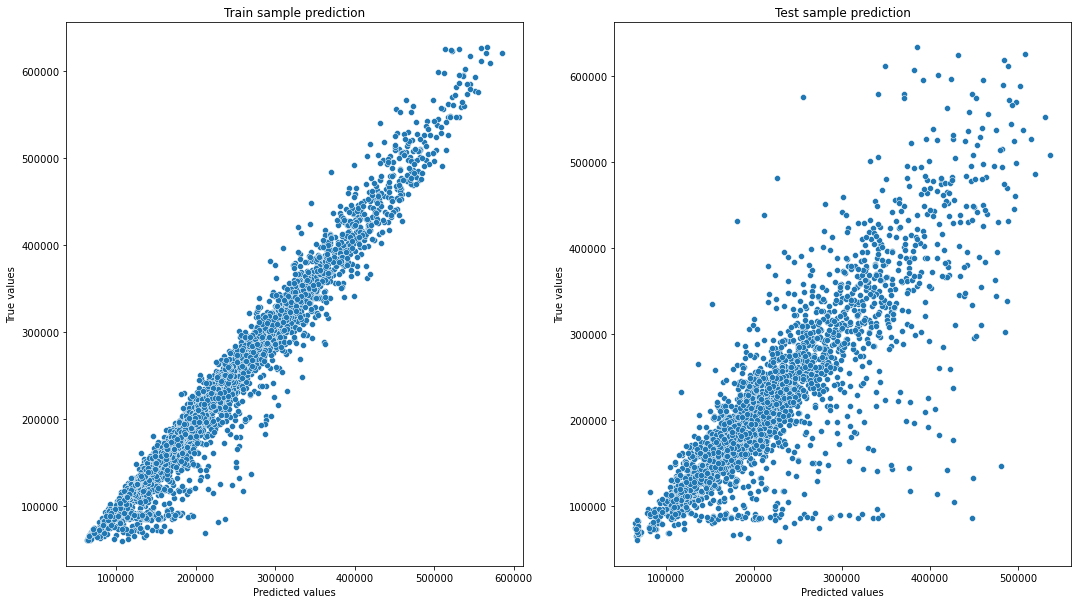

In [404]:
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

# Тестовая выборка

In [413]:
test_df["Price"] = y_test_preds

In [418]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,4567,44,2.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1,1,B,154347.079161
1,5925,62,2.0,52.568133,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,0,0,A,115983.226202
2,960,27,2.0,59.463678,40.370943,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,0,1,B,143415.339996
3,3848,23,2.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,0,0,B,111319.707385
4,746,74,2.0,53.837056,42.269644,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,0,6,B,220520.359621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,6.0,1962,0.069660,B,B,31,6119,4,1,2,B,175718.258201
4996,16138,38,2.0,104.521465,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,0,7,B,419475.353565
4997,3912,101,2.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,2,5,B,144800.830903
4998,5722,10,2.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,0,11,B,190351.499511


In [419]:
test_df.to_csv('rf_submit.csv', columns=["Id", "Price"], index=False)